In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from itertools import combinations
import networkx as nx
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.patches import Circle

In [2]:
def make_plot(dis_rank, network, num_GOterms,weight_thresh, figname):
    # load the disease dataframe and get the desired disease
    fp = "../results//disease_evals/"
    dfdis = pd.read_csv(fp + f"DisMet__ce_dm_dr_hs_mm_sc__{network}.tsv",sep="\t")
    name = dfdis.iloc[dis_rank,:]["name"]
    log2p_score = dfdis.iloc[dis_rank,:]["log2p"]
    num_train = dfdis.iloc[dis_rank,:]["num_train_pos"] + dfdis.iloc[dis_rank,:]["num_test_pos"]
    ID = dfdis.iloc[dis_rank,:]["ID"].replace(":","")
    # get all the GO terms for top 10 in each species and find the unqiue terms
    allGOs = []
    species_dict = {}
    name_dict = {}
    for aspecies in ["ce","dm","dr","hs","mm","sc"]:
        dfGO = pd.read_csv(fp + f"{dis_rank}__{ID}__GO__{aspecies}__{network}__ce_dm_dr_hs_mm_sc.tsv",sep="\t")
        dfGO = dfGO[dfGO["FDR"]<0.05]
        allGOs = allGOs + dfGO["ID"].tolist()[0:num_GOterms]
        species_dict[aspecies] = dfGO["ID"].tolist()[0:num_GOterms]
        for idx, anID in enumerate(dfGO["ID"].tolist()[0:num_GOterms]):
            name_dict[anID] = dfGO["Name"].tolist()[0:num_GOterms][idx]
    allGOs = list(set(allGOs))
    # make the graph
    fp_edge = "../results/disease_GO/"
    df_edge =  pd.read_csv(fp_edge+f"edges__{dis_rank}__{network}__20.tsv",sep="\t")
    df_edge = df_edge[df_edge["Weight"]>weight_thresh]
    df_edge = df_edge[(df_edge["Node1"].isin(allGOs))&(df_edge["Node2"].isin(allGOs))]
#     df_edge.to_csv(f"20230302_GONetwork/{dis_rank}_{network}_{num_GOterms}_{weight_thresh}_edges.tsv",
#                    sep="\t",index=False,header=True)
    edgelist = list(df_edge.itertuples(index=False))
    edgelist = [f"{item[0]} {item[1]} {item[2]}" for item in edgelist]
    G = nx.parse_edgelist(edgelist, data=(('weight',float),))
    # find nodes that have zero overlap
    df_zeros = pd.read_csv("../results/table_data/ZeroOverlaps.tsv", sep="\t")
    df_zeros = df_zeros[df_zeros["DOID"]==dfdis.iloc[dis_rank,:]["ID"]]
    allZeroIDs = df_zeros["Term ID"].tolist()
    ZeroIDs = list(set([item for item in allZeroIDs if item in list(G.nodes())]))
    # set some node attributes
    color_dict ={"hs":"#1B9E77", "mm":"#D95F02", "dr":"#7570B3",
             "dm":"#E7298A","ce":"#66A61E", "sc":"#A6761D"}
    node_attr = {}
    for anode in G.nodes():
        node_attr[anode] = {}
        slice_size = []
        slice_color = []
        node_species =[]
        for aspecies in ["ce","dm","dr","hs","mm","sc"]:
            if anode in species_dict[aspecies]:
                slice_size.append(1)
                slice_color.append(color_dict[aspecies])
                node_species.append(aspecies)
        node_attr[anode]["slice_size"] = slice_size
        node_attr[anode]["slice_color"] = slice_color
        node_attr[anode]["node_name"] = name_dict[anode]
        node_attr[anode]["node_species"] = node_species
#     with open(f"20230302_GONetwork/{dis_rank}_{network}_{num_GOterms}_{weight_thresh}_nodes.json", "w") as myf:
#         json.dump(node_attr, myf, ensure_ascii=False, indent=4)
    # make the plot
    fig, ax = plt.subplots(figsize=(12,12))
    pos = nx.circular_layout(G)
    plot_weights = list(nx.get_edge_attributes(G,'weight').values())
    weight_scale = 1
    nx.draw_networkx_edges(G, pos=pos,ax=ax,
                           width=[weight_scale*item for item in plot_weights],
                           alpha=0.4)
    skipped = 0
    for node_idx, anode in enumerate(G.nodes):
        ax.pie(node_attr[anode]["slice_size"],
               center=pos[anode], 
               colors = node_attr[anode]["slice_color"],
               radius=0.05)
        xlabel = pos[anode][0]-0.01
        ylabel =pos[anode][1]-0.01
        piscale = (2*np.pi)/len(G.nodes)
        if np.cos(piscale*node_idx) >= 0:   
            xadjust = 0.07*np.cos(piscale*node_idx)
        else:
            xadjust = 0.13*np.cos(piscale*node_idx)
        if np.sin(piscale*node_idx) >= 0:
            yadjust = 0.09*np.sin(piscale*node_idx)
        else:
            yadjust = 0.11*np.sin(piscale*node_idx)
        ax.annotate(f"{node_idx}",(xlabel+xadjust,ylabel+yadjust))
        incers = 3.8/len(G.nodes)
        if anode in ZeroIDs:
            txt_color = "bold"
        else:
            txt_color = "normal"
        if node_idx == int(len(G.nodes)/2)+1:
            skipped = -0.5
        if node_idx <= len(G.nodes)/2:
            txt_x = 1.23
            row_idx = node_idx
        else:
            txt_x = 2.3
            row_idx = node_idx - len(G.nodes)/2
        if node_idx > 9:
            myempty = "       "
            myempty2 = ""
        else:
            myempty = "       "
            myempty2 =  "  "
        if len(node_attr[anode]["node_name"]) >= 35:
            words = node_attr[anode]["node_name"].split(" ")
            char_cnt = 0
            word_split = None
            for idx_word, aword in enumerate(words):
                if char_cnt > 20:
                    word_split = idx_word
                    break
                else:
                    char_cnt = char_cnt + len(aword)
#             half_text = int(len(node_attr[anode]["node_name"])/2)
            top_row = " ".join(words[0:word_split])
            bottom_row = " ".join(words[word_split:])
#             txt_label = node_attr[anode]["node_name"][0:word_split] + "-\n%s"%myempty + node_attr[anode]["node_name"][word_split:]
            txt_label = top_row + "\n%s"%myempty + bottom_row
            skipped = skipped + 0.5
        else:
            txt_label = node_attr[anode]["node_name"]
        ax.annotate(f'{myempty2}{node_idx} : {txt_label}',
                    (txt_x,1.05-(incers*(row_idx+skipped))),fontsize= 8, fontweight=txt_color)
#         if len(node_attr[anode]["node_name"]) >= 40:
#             skipped = 0
    for anode in ZeroIDs:
#         ax.annotate(node_attr[anode]["node_name"],pos[anode])
        ax.plot(pos[anode][0], pos[anode][1], 'o',
                ms=18, mec='k', mfc='none', mew=2)
#     ax.set_title(f"The name of the disease is {name} with a log2p of {log2p_score} - top {num_GOterms}")
    plt.xlim(-1.2,3)
    plt.ylim(-1.3,1.5)
    # make a legend
    spec_convert = {"hs":"human","mm":"mouse","dr":"fish","dm":"fly","ce":"worm","sc":"yeast"}
    handles = []
    labels = []
    for aspecies, acolor in color_dict.items():
        handles.append(Line2D([], [], color="white", marker='o',
                              markerfacecolor=acolor,markersize=13))
        labels.append(spec_convert[aspecies])
    fig.legend(handles, labels, ncol=6, loc = 10, bbox_to_anchor=(0.35,0.25), \
        frameon=False, fontsize=8)
    fig.savefig(f"../figures/{figname}")

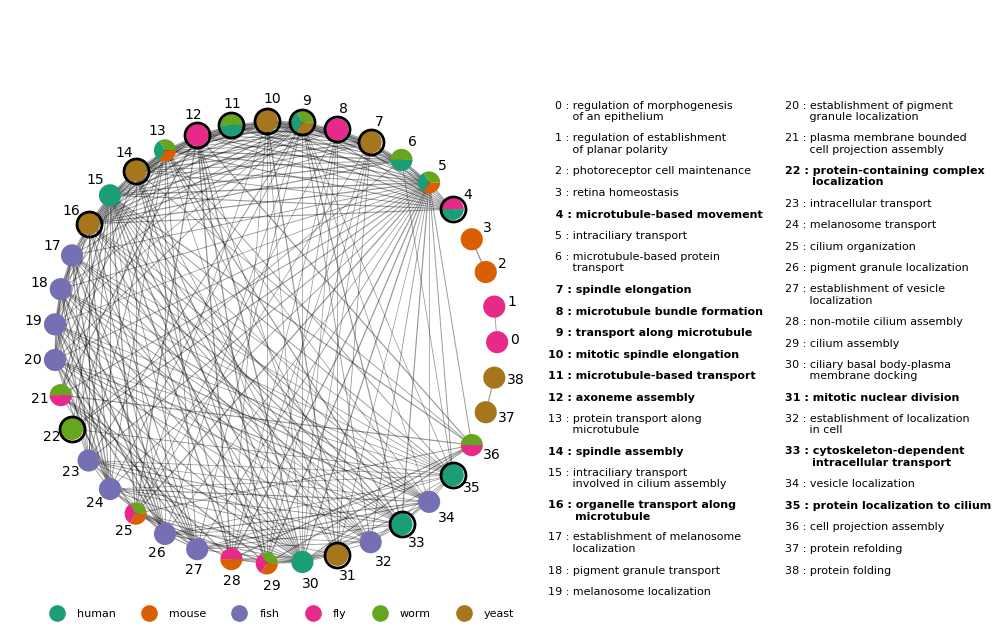

In [3]:
# change some inputs
dis_rank = 1 # diseases sorted by top performance of study bias holdout (0 indexed)
network = "IMP"  # IMP or BioGRID
num_GOterms = 10
weight_thresh = 0.5
figname = "Fig5.pdf"
make_plot(dis_rank, network, num_GOterms,weight_thresh,figname)

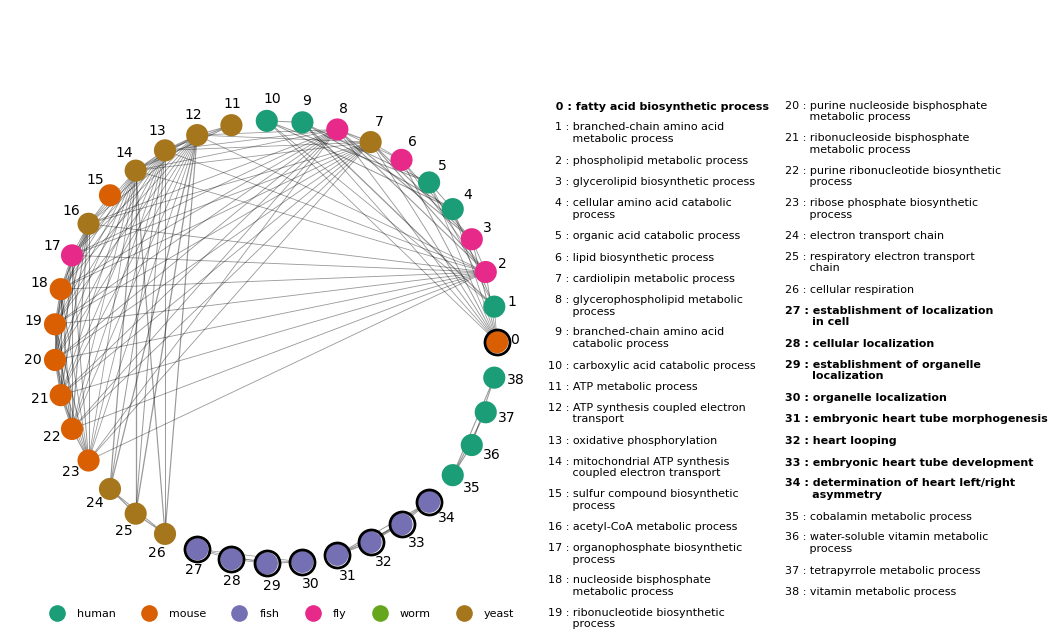

In [4]:
# change some inputs
dis_rank = 2 # diseases sorted by top performance of study bias holdout (0 indexed)
network = "BioGRID"  # IMP or BioGRID
num_GOterms = 10
weight_thresh = 0.5
figname = "FigSM21.pdf"
make_plot(dis_rank, network, num_GOterms,weight_thresh,figname)